In [1]:
import pandas as pd
import os
import pickle
os.chdir('..')
import plotly.express as px
from utils import *

# ml imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import DMatrix
import xgboost as xgb

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# logging
from matplotlib import pyplot as plt
import wandb
from wandb.xgboost import WandbCallback
from bayes_opt import BayesianOptimization

wandb.login()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [2]:
os.getcwd()

'c:\\Users\\nik\\Desktop\\Berkeley_Projects\\WattCast'

In [2]:
# df_first = pd.read_csv(r'data\raw_data\UTC_id1_data.csv', sep=';')
# df_first.index = pd.to_datetime(df_first['timestamp'], format='%d.%m.%Y %H:%M')
# df_first = df_first.iloc[:,[1]]


# df_first = pd.read_csv(r'data\cleaned_data\5_household\power\15min_36_train.csv', index_col=0, parse_dates=True)


# df_first = df_first.resample('15min').mean()
# df_first.columns = ['power']

In [61]:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')
model_dir = os.path.join(os.getcwd(), 'models')


df_train = pd.read_hdf(os.path.join(dir_path, '5_household.h5'), key='household_1/15min/train_target')
df_val = pd.read_hdf(os.path.join(dir_path, '5_household.h5'), key='household_1/15min/val_target')
df_test = pd.read_hdf(os.path.join(dir_path, '5_household.h5'), key='household_1/15min/test_target')

df_first = pd.concat([df_train, df_val, df_test], axis=0)


Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [62]:
# Data cleaning
#-----------------------#
df = remove_duplicate_index(df_first)

df = remove_days(df, 0.2)

df = remove_non_positive_values(df)

df_clean = df.copy()

In [63]:
px.line(df_clean)

Text(0.5, 0, 'Power consumption [W]')

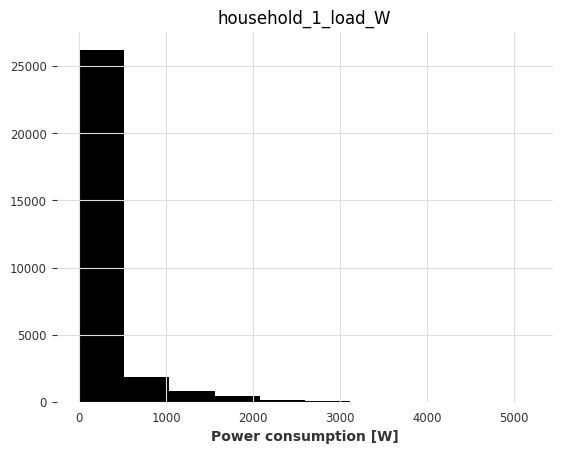

In [64]:
df_clean.hist()
plt.xlabel('Power consumption [W]')

In [65]:
config_features = {
    'holidays': True,
    'holidays_country': 'AT',
    'peaks': True,
    'lagged_days': [1,7,14],
    'boxcox': True,
    'lam': None,
    'cumsum': False,
    'datetime': True,
    }



In [40]:
wandb.init(
    project="XGBoost",
    )

wandb.config.update(config_features)

config = wandb.config

#-----------------------#


Test-mphe,▂▂▃▃▃▃▄▄▄▄▄▅▆▇▆▇████▁▁▂▂▂▂▂▃▃▃
Test-peak_error,▆▆▆▇▇▆▆█▇██▄▇▅▆▇▇▆▇▄▆▁▂▂▄▄▅▇██
Train-mphe,▇▅▄▃▂▂▂▁▁▁█▆▅▄▃▃▂▂▂▁▇▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁█▆▅▄▄▃▂▂▁▁█▆▅▄▃▃▂▂▁▁
best_iteration,▁▁▁
best_score,▃█▁
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09019
Train-peak_error,0.02844
best_iteration,9
best_score,0.02844


In [66]:

df = df_clean.copy()
# Feature Engineering
#-----------------------#
if config.boxcox:
    df, config.lam = boxcox_transform(df)



Text(0.5, 0, 'Power consumption [W]')

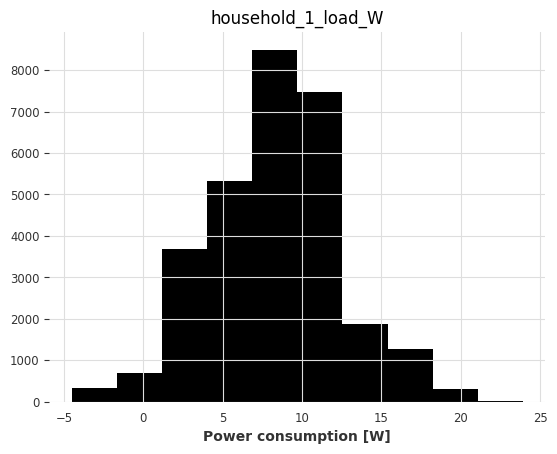

In [67]:
df.hist()
plt.xlabel('Power consumption [W]')

In [68]:

# scaling the data

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

# long to wide format, because we are doing daily predictions
df_pivot = timeseries_dataframe_pivot(df).dropna()
n_timesteps_per_output = df_pivot.shape[1]

# peaks
if config.peaks:
    df_peak_feature = timeseries_peak_feature_extractor(df)
    for i in config.lagged_days:
        df_peak_feature_shifted = df_peak_feature.shift(i)
        df_peak_feature_shifted.columns = [f"{col}_lag_{i}" for col in df_peak_feature_shifted.columns]
        df_pivot = pd.merge(df_pivot, df_peak_feature_shifted, left_index=True, right_index=True, how='left')
        df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot = df_pivot.dropna()

# past information
if config.cumsum:
    df_pivot["load_of_last_day"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(1)
    df_pivot["load_of_same_day_last_week"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(7)


# holidays
if config.holidays:
    years = get_year_list(df_pivot)
    df_holidays_dummies = get_holidays(years, config.holidays_country)
    df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
    df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

# datetime features
if config.datetime:
    df_pivot = create_datetime_features(df_pivot)

df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

#-----------------------#

# Splits 

#-----------------------#
test_size = 0.2
train, test = train_test_split(df_final, test_size=test_size, shuffle=True, random_state=42)
test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_output]).index

#features and target
X_train = train.iloc[:,n_timesteps_per_output:]
y_train = train.iloc[:,:n_timesteps_per_output]

X_test = test.iloc[:,n_timesteps_per_output:]
y_test = test.iloc[:,:n_timesteps_per_output]


scaler_features = MinMaxScaler()
X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

#-----------------------#


dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)


In [73]:
params = {'colsample_bytree': 0.9, 
            'learning_rate': 0.25, # 4. this parameter can really help to adjust the optimism of the model
            'max_depth': 13, 
            'min_child_weight': 1, # 1. want higher peaks? decrease this parameter
            'reg_lambda': 0.2, # 3. l2 regularization, this parameter can really help to adjust the optimism of the model
            'subsample': 0.6,
            'gamma': 0,
            'objective': 'reg:pseudohubererror',
            'huber_slope': 0.18, # 2. between 0.08 and 0.15 seems good for this data
            'tree_method': 'gpu_hist', # for faster computation
            'predictor': 'gpu_predictor', # for faster computation
            'num_parallel_tree': 1,
             }

        
wandb.config.update(params)
model = xgb.train(dtrain= dtrain, params=params, 
                  early_stopping_rounds=50,
                  evals=[(dtest, "Test"), (dtrain, "Train")], 
                  custom_metric=peak_error, maximize=False, verbose_eval=10, callbacks=[WandbCallback()])
predictions = model.predict(dtest)



[0]	Test-mphe:0.00747	Test-peak_error:0.16069	Train-mphe:0.00560	Train-peak_error:0.16333
[9]	Test-mphe:0.00760	Test-peak_error:0.07738	Train-mphe:0.00057	Train-peak_error:0.03982


In [74]:
predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, config.lam)
gt = df_first.loc[test_idx].values.flatten()

df_compare = pd.DataFrame({
                        'ground truth':gt,
                        'prediction': predictions_reshaped
                        }
                        )


# -----------------------#
fig2 = px.line(df_compare)
fig2.update_layout(title='XGBoost Predictions vs Ground Truth: Michael Stadler Household Data')
fig2.show()
wandb.log({"Line-Plot":fig2})



In [ ]:
def xgb_obj(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators , reg_lambda, reg_alpha, huber_slope, gamma):
    
    wandb.init(project='XGBoost')
    wandb.config.update(config_features)
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': int(n_estimators),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'huber_slope': huber_slope,
        'gamma': gamma, 
        # defaults
        'objective': 'reg:pseudohubererror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    wandb.config.update(params)

    model = xgb.train(params, dtrain, evals=[(dtest, "Test"), (dtrain, "Train")],
                      early_stopping_rounds=5, feval=peak_error, maximize=False, verbose_eval=10, callbacks = [WandbCallback()])
    predictions = model.predict(dtest)

    predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, 0.22)
    gt = df_first.loc[test_idx].values.flatten()

    df_compare = pd.DataFrame({
                            'gt':gt,
                            'per_timestep': predictions_reshaped
                            }
                            )
    


    fig = px.line(df_compare, y=['gt', 'per_timestep'])
    wandb.log({"Side-by-Side": fig})
    # -----------------------

    
    
    error = peak_error(predictions, dtest)[1]
    dtw_distance = dtw_error(predictions, dtest)[1]
    wandb.log({"dtw_distance": dtw_distance})

    
    return -error  # Negative since BayesOpt minimizes the objective function


In [ ]:

# Define bounds for hyperparameters
pbounds = {
    'learning_rate': (0.05, 0.3),
    'max_depth': (7, 20),
    'min_child_weight': (1, 8),
    'subsample': (0.7, 1),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (0.05, 0.2),
    'reg_alpha': (0.1, 0.2),
    'n_estimators': (500, 2500),
    'huber_slope': (0.05, 0.5),
    'gamma': (0, 0.3),
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_obj, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=20, n_iter=100)

# Print optimal hyperparameters and their corresponding error
print(optimizer.max)